# Uso do XGboost na deteção de fraudes em transações de Cartões de Crédito

Este é um projeto pessoal que faz parte dos meus estudos em Data Science, utilizando Python para análise e modelagem de dados.

O conjunto de dados está disponível no Kaggle e refere-se a transações realizadas com cartões de crédito em setembro de 2013 por titulares de cartões europeus, ocorrendo ao longo de dois dias.

O objetivo deste projeto é construir um modelo preditivo, utilizando o algoritmo XGBoost, que, de maneira o mais precisa possível, consiga identificar se uma transação é suspeita de fraude ou não. O dataset contém apenas variáveis numéricas de entrada, que resultam de uma transformação por Análise de Componentes Principais (PCA). As características, como V1, V2, ..., V28, representam os principais componentes extraídos pelo PCA, sendo que os dados originais não estão disponíveis. Em razão disso, informações adicionais sobre as características não podem ser fornecidas.

O dataset original pode ser acessado no Kaggle através do seguinte link:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

## Instalação e Importações

Nesta seção, serão realizadas as instalações e importações dos módulos e bibliotecas necessárias para o projeto. Devido a problemas na versão 1.6.0 do scikit-learn, que impedia a criação correta das pipelines, neste projeto foram utilizadas as seguintes versões específicas das bibliotecas:

- scikit-learn versão 1.5.2
- xgboost versão 2.1.3

Essas versões foram escolhidas para garantir o funcionamento adequado das funcionalidades necessárias.

In [328]:
import numpy as np # Manipulação de Dados
import pandas as pd  

import matplotlib as plt # Plotagem dos Gráficos

import sklearn # Métricas de Avaliação e Ferramentas utilitárias
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn import metrics

import xgboost # Algoritmo usado para a Classificação Binária
from xgboost import XGBClassifier

In [329]:
print(sklearn.__version__)
print(xgboost.__version__)

1.5.2
2.1.3


## Carregando e Compreendendo os Dados

## Dicionário de Variáveis

- ***V1, V2, …, V28:*** Componentes principais obtidos através da transformação PCA. Estes são valores numéricos que representam as variáveis originais após a redução de dimensionalidade com PCA.

- ***Time***: Tempo, em segundos, decorrido entre cada transação e a primeira transação no dataset.

- ***Amount***: Valor da transação. Esta variável pode ser usada em modelos de aprendizado que consideram custos sensíveis ao exemplo.

- ***Class***: Variável de resposta, indicando se a transação é fraudulenta. Assume valor 1 em caso de fraude e 0 caso contrário.

In [330]:
df_data = pd.read_csv('creditcard.csv')

In [331]:
df_data.shape

(284805, 31)

In [332]:
df_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [333]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284805 entries, 0 to 284804
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284805 non-null  int64  
 1   V1      284805 non-null  float64
 2   V2      284805 non-null  float64
 3   V3      284805 non-null  float64
 4   V4      284805 non-null  float64
 5   V5      284805 non-null  float64
 6   V6      284805 non-null  float64
 7   V7      284805 non-null  float64
 8   V8      284805 non-null  float64
 9   V9      284805 non-null  float64
 10  V10     284805 non-null  float64
 11  V11     284805 non-null  float64
 12  V12     284805 non-null  float64
 13  V13     284805 non-null  float64
 14  V14     284805 non-null  float64
 15  V15     284805 non-null  float64
 16  V16     284805 non-null  float64
 17  V17     284805 non-null  float64
 18  V18     284805 non-null  float64
 19  V19     284805 non-null  float64
 20  V20     284805 non-null  float64
 21  V21     28

In [334]:
def calcula_prevalencia(y_actual):
    print(f'Prevalência: {sum(y_actual) * 100/ len(y_actual):.3f}%')

def calcula_valores_validos(y_actual):
    print(f'Valores Válidos em {col}: {sum(y_actual.notnull()) * 100/ len(y_actual):.3f}%')

In [335]:
for col in df_data.columns:
    calcula_valores_validos(df_data[col])

Valores Válidos em Time: 100.000%
Valores Válidos em V1: 100.000%
Valores Válidos em V2: 100.000%
Valores Válidos em V3: 100.000%
Valores Válidos em V4: 100.000%
Valores Válidos em V5: 100.000%
Valores Válidos em V6: 100.000%
Valores Válidos em V7: 100.000%
Valores Válidos em V8: 100.000%
Valores Válidos em V9: 100.000%
Valores Válidos em V10: 100.000%
Valores Válidos em V11: 100.000%
Valores Válidos em V12: 100.000%
Valores Válidos em V13: 100.000%
Valores Válidos em V14: 100.000%
Valores Válidos em V15: 100.000%
Valores Válidos em V16: 100.000%
Valores Válidos em V17: 100.000%
Valores Válidos em V18: 100.000%
Valores Válidos em V19: 100.000%
Valores Válidos em V20: 100.000%
Valores Válidos em V21: 100.000%
Valores Válidos em V22: 100.000%
Valores Válidos em V23: 100.000%
Valores Válidos em V24: 100.000%
Valores Válidos em V25: 100.000%
Valores Válidos em V26: 100.000%
Valores Válidos em V27: 100.000%
Valores Válidos em V28: 100.000%
Valores Válidos em Amount: 100.000%
Valores Válidos

In [336]:
calcula_prevalencia(df_data['Class'])

Prevalência: 0.173%


Existe um grande desbalanceamento entre as classes, mas decidimos testar o modelo dessa forma, pois o viés resultante pode não ser tão relevante. Além disso, o grande volume de dados pode compensar esse desbalanceamento, minimizando o impacto no desempenho do modelo.

## Engenharia de Atributos

In [337]:
df_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [338]:
valores_unicos = df_data.nunique()

In [339]:
# Lista dos atributos que serão utilizados como entrada
atributos = [x for x in df_data.columns if (x in valores_unicos and x != 'Class')]

In [340]:
atributos

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

## Criação do Pipeline de Pré-Processamento


In [341]:
class PipeSteps(BaseEstimator, TransformerMixin):

    def __init__(self, columns = []):
        self.columns = columns
          
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X = X.copy()
        return X

In [342]:
class SelecionaColunas(PipeSteps):
    def transform(self, X):
        X = X.copy()
        return X[self.columns]

In [343]:
# Faz o tratamento de possíveis valores ausentes
class PreencheDados(PipeSteps): 
    def fit(self, X, y=None):
        self.means = {col: X[col].mean() for col in self.columns}
        return self 

    def transform(self, X):
        X = X.copy() 
        for col in X.columns:
            X[col] = X[col].fillna(self.means[col])
        return X
    

In [344]:
# Realiza a padronização dos Dados utilizando o StandardScaler
class PadronizaDados(PipeSteps):
    def fit(self, X, y = None ):
        self.scaler = StandardScaler() 
        self.scaler.fit(X[self.columns])
        return self
        
    def transform(self, X, y =None):
        X = X.copy()
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

## Criação do Pipeline de Machine Learning

In [345]:
pipe_prepropcessamento = Pipeline([('feature_selection', SelecionaColunas(atributos)),
                                       ('fill_missing', PreencheDados(atributos)),
                                       ('standard_scaling', PadronizaDados(atributos))])

In [346]:
pipe_prepropcessamento

Pipeline(steps=[('feature_selection',
                 SelecionaColunas(columns=['Time', 'V1', 'V2', 'V3', 'V4', 'V5',
                                           'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
                                           'V12', 'V13', 'V14', 'V15', 'V16',
                                           'V17', 'V18', 'V19', 'V20', 'V21',
                                           'V22', 'V23', 'V24', 'V25', 'V26',
                                           'V27', 'V28', 'Amount'])),
                ('fill_missing',
                 PreencheDados(columns=['Time', 'V1', 'V2', 'V3', 'V4', 'V5',
                                        'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
                                        'V12', 'V13', 'V14', 'V15', 'V16',
                                        'V17', 'V18', 'V19', 'V20', 'V21',
                                        'V22', 'V23', 'V24', 'V25', 'V26',
                                        'V27', 'V28', 'Amount'])),
                ('standard_scaling',
                 PadronizaDados(columns=['Time', 'V1', 'V2', 'V3', 'V4', 'V5',
                                         'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
                                         'V12', 'V13', 'V14', 'V15', 'V16',
                                         'V17', 'V18', 'V19', 'V20', 'V21',
                                         'V22', 'V23', 'V24', 'V25', 'V26',
                                         'V27', 'V28', 'Amount']))])

In [347]:
pipe_final = Pipeline([
    ('preprocessing', pipe_prepropcessamento),
    ('learning', XGBClassifier(random_state = 42, eval_metric = 'auc', objective = 'binary:logistic') )
])

## Preparação dos Dados

In [348]:
X = df_data[atributos]

In [349]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284800,172784,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,...,-0.256922,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,2.68
284801,172785,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,...,0.000676,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,2.69
284802,172786,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,172787,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79


In [350]:
y = df_data['Class']

In [351]:
y

0         0
1         0
2         0
3         0
4         0
         ..
284800    0
284801    0
284802    0
284803    0
284804    0
Name: Class, Length: 284805, dtype: int64

In [352]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.30, random_state = 42)

## Treinamento e Avaliação do Modelo

In [353]:
pipe_final.fit(X_treino, y_treino)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('feature_selection',
                                  SelecionaColunas(columns=['Time', 'V1', 'V2',
                                                            'V3', 'V4', 'V5',
                                                            'V6', 'V7', 'V8',
                                                            'V9', 'V10', 'V11',
                                                            'V12', 'V13', 'V14',
                                                            'V15', 'V16', 'V17',
                                                            'V18', 'V19', 'V20',
                                                            'V21', 'V22', 'V23',
                                                            'V24', 'V25', 'V26',
                                                            'V27', 'V28',
                                                            'Amount'])),
                                 ('fill_missing',
                                  PreencheDados(columns=['Time', 'V1', 'V2',
                                                         'V3', 'V4', 'V5', 'V6',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [354]:
previsoes = pipe_final.predict(X_teste)

In [355]:
# AUPRC
precision, recall, thresholds = precision_recall_curve(y_teste, previsoes)
auprc = auc(recall, precision)

# AUC-ROC
roc_auc = roc_auc_score(y_teste, previsoes)

# Relatório de classificação 
report = classification_report(y_teste, previsoes)


print(f'AUPRC: {auprc:.3f}')
print(f'ROC_AUC: {roc_auc:.3f}')
print(report)

AUPRC: 0.881
ROC_AUC: 0.917
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85303
           1       0.93      0.83      0.88       139

    accuracy                           1.00     85442
   macro avg       0.96      0.92      0.94     85442
weighted avg       1.00      1.00      1.00     85442



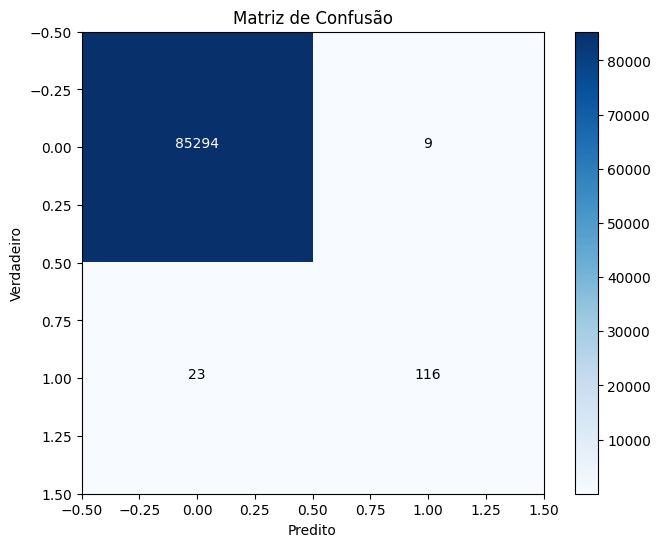

Matriz de Confusão: 
[[85294     9]
 [   23   116]]


In [356]:
import matplotlib.pyplot as plt

# Calcular a matriz de confusão
cm = confusion_matrix(y_teste, previsoes)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')

# Adicionar anotações na matriz de confusão
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

print(f'Matriz de Confusão: \n{cm}')

## Engenharia de Atributos(Segunda Iteração)

Agora, na segunda iteração, aplicaremos a técnica de Undersampling para balancear as classes do conjunto de dados. Essa abordagem visa reduzir o número de exemplos da classe majoritária, de modo a equilibrar a distribuição das classes e melhorar o desempenho do modelo.

### Balanceamento de classes (Undersampling)

In [357]:
df_data_mod = df_data.sample(n = len(df_data)) 
df_data_mod = df_data_mod.reset_index(drop = True)

In [358]:
df_data_mod

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,126104,2.122829,0.035725,-2.404487,-0.272007,0.967402,-0.752347,0.611916,-0.307309,0.010061,...,0.166127,0.547137,-0.064376,0.269880,0.462413,0.221254,-0.094324,-0.087801,3.70,0
1,147240,1.788792,-0.337726,-0.824577,1.479888,0.086002,0.385607,-0.075023,0.099840,0.760822,...,-0.240269,-0.480050,0.205490,0.687597,0.022244,-0.877915,0.024816,-0.034525,71.00,0
2,120758,-0.000525,1.129022,-0.240554,0.391084,1.018093,-0.948272,1.554870,-0.408803,-0.509938,...,0.141475,0.550873,-0.271679,-0.069218,0.221842,-0.574120,-0.066370,0.029720,20.83,0
3,151977,0.892824,-1.440698,-0.637940,3.912871,0.099291,2.433288,-0.308891,0.603227,-0.113826,...,0.484969,0.487304,-0.122694,-0.598803,-0.594563,0.062841,-0.033426,0.038254,460.65,0
4,45796,-1.460097,0.389690,2.214583,-0.213149,0.662502,2.495735,0.178647,0.494978,0.449827,...,0.124411,0.794129,-0.135273,-1.334098,-0.306967,-0.503139,-0.421880,-0.119456,61.72,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284800,10307,1.105355,0.149907,0.601394,0.624418,-0.014474,0.319088,-0.289845,0.151188,1.101859,...,-0.294625,-0.616258,0.186988,-0.359945,0.002107,0.097190,-0.030890,-0.002465,16.00,0
284801,77719,-1.321370,-0.193974,0.718134,-4.473638,-0.502477,-0.685349,-0.149035,-1.728874,0.986819,...,1.105496,-0.673047,0.065500,-0.468737,0.355856,-1.007237,0.643169,0.140269,64.11,0
284802,59711,0.921169,-0.427775,1.104404,1.160505,-0.336235,1.806443,-0.974814,0.775733,1.113719,...,0.052552,0.379434,0.122570,-0.994550,0.037707,-0.277717,0.129141,0.024095,32.04,0
284803,169963,-1.105443,1.084307,0.819215,-0.172630,-0.680590,-0.427553,-0.487449,0.827842,0.155368,...,0.450994,1.249179,-0.228126,0.052224,-0.252007,-0.131385,-0.144450,0.020031,0.80,0


In [359]:
indice = df_data_mod.Class == 1

In [360]:
df_data_pos = df_data_mod[indice]
df_data_neg = df_data_mod[~indice]

In [361]:
calcula_prevalencia(df_data_pos.Class)

Prevalência: 100.000%


In [362]:
calcula_prevalencia(df_data_neg.Class)

Prevalência: 0.000%


In [363]:
for col in df_data_pos.columns:
    calcula_valores_validos(df_data_pos[col])

Valores Válidos em Time: 100.000%
Valores Válidos em V1: 100.000%
Valores Válidos em V2: 100.000%
Valores Válidos em V3: 100.000%
Valores Válidos em V4: 100.000%
Valores Válidos em V5: 100.000%
Valores Válidos em V6: 100.000%
Valores Válidos em V7: 100.000%
Valores Válidos em V8: 100.000%
Valores Válidos em V9: 100.000%
Valores Válidos em V10: 100.000%
Valores Válidos em V11: 100.000%
Valores Válidos em V12: 100.000%
Valores Válidos em V13: 100.000%
Valores Válidos em V14: 100.000%
Valores Válidos em V15: 100.000%
Valores Válidos em V16: 100.000%
Valores Válidos em V17: 100.000%
Valores Válidos em V18: 100.000%
Valores Válidos em V19: 100.000%
Valores Válidos em V20: 100.000%
Valores Válidos em V21: 100.000%
Valores Válidos em V22: 100.000%
Valores Válidos em V23: 100.000%
Valores Válidos em V24: 100.000%
Valores Válidos em V25: 100.000%
Valores Válidos em V26: 100.000%
Valores Válidos em V27: 100.000%
Valores Válidos em V28: 100.000%
Valores Válidos em Amount: 100.000%
Valores Válidos

In [364]:
for col in df_data_neg.columns:
    calcula_valores_validos(df_data_neg[col])

Valores Válidos em Time: 100.000%
Valores Válidos em V1: 100.000%
Valores Válidos em V2: 100.000%
Valores Válidos em V3: 100.000%
Valores Válidos em V4: 100.000%
Valores Válidos em V5: 100.000%
Valores Válidos em V6: 100.000%
Valores Válidos em V7: 100.000%
Valores Válidos em V8: 100.000%
Valores Válidos em V9: 100.000%
Valores Válidos em V10: 100.000%
Valores Válidos em V11: 100.000%
Valores Válidos em V12: 100.000%
Valores Válidos em V13: 100.000%
Valores Válidos em V14: 100.000%
Valores Válidos em V15: 100.000%
Valores Válidos em V16: 100.000%
Valores Válidos em V17: 100.000%
Valores Válidos em V18: 100.000%
Valores Válidos em V19: 100.000%
Valores Válidos em V20: 100.000%
Valores Válidos em V21: 100.000%
Valores Válidos em V22: 100.000%
Valores Válidos em V23: 100.000%
Valores Válidos em V24: 100.000%
Valores Válidos em V25: 100.000%
Valores Válidos em V26: 100.000%
Valores Válidos em V27: 100.000%
Valores Válidos em V28: 100.000%
Valores Válidos em Amount: 100.000%
Valores Válidos

In [365]:
valor_minimo = np.min([len(df_data_neg),len(df_data_pos)])

In [366]:
valor_minimo

492

In [367]:
df_final = pd.concat([df_data_pos.sample(n = valor_minimo, random_state = 42),
                      df_data_neg.sample(n = valor_minimo, random_state = 42)],
                     axis = 0,
                     ignore_index = True)

In [368]:
calcula_prevalencia(df_final.Class)

Prevalência: 50.000%


In [369]:
for col in df_final.columns:
    calcula_valores_validos(df_final[col])

Valores Válidos em Time: 100.000%
Valores Válidos em V1: 100.000%
Valores Válidos em V2: 100.000%
Valores Válidos em V3: 100.000%
Valores Válidos em V4: 100.000%
Valores Válidos em V5: 100.000%
Valores Válidos em V6: 100.000%
Valores Válidos em V7: 100.000%
Valores Válidos em V8: 100.000%
Valores Válidos em V9: 100.000%
Valores Válidos em V10: 100.000%
Valores Válidos em V11: 100.000%
Valores Válidos em V12: 100.000%
Valores Válidos em V13: 100.000%
Valores Válidos em V14: 100.000%
Valores Válidos em V15: 100.000%
Valores Válidos em V16: 100.000%
Valores Válidos em V17: 100.000%
Valores Válidos em V18: 100.000%
Valores Válidos em V19: 100.000%
Valores Válidos em V20: 100.000%
Valores Válidos em V21: 100.000%
Valores Válidos em V22: 100.000%
Valores Válidos em V23: 100.000%
Valores Válidos em V24: 100.000%
Valores Válidos em V25: 100.000%
Valores Válidos em V26: 100.000%
Valores Válidos em V27: 100.000%
Valores Válidos em V28: 100.000%
Valores Válidos em Amount: 100.000%
Valores Válidos

In [370]:
X = df_final[atributos]

In [371]:
y = df_final['Class']

In [372]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.30, random_state = 42)

## Treinamento e Avaliação(Segunda Iteração)

In [373]:
pipe_final.fit(X_treino, y_treino)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('feature_selection',
                                  SelecionaColunas(columns=['Time', 'V1', 'V2',
                                                            'V3', 'V4', 'V5',
                                                            'V6', 'V7', 'V8',
                                                            'V9', 'V10', 'V11',
                                                            'V12', 'V13', 'V14',
                                                            'V15', 'V16', 'V17',
                                                            'V18', 'V19', 'V20',
                                                            'V21', 'V22', 'V23',
                                                            'V24', 'V25', 'V26',
                                                            'V27', 'V28',
                                                            'Amount'])),
                                 ('fill_missing',
                                  PreencheDados(columns=['Time', 'V1', 'V2',
                                                         'V3', 'V4', 'V5', 'V6',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [374]:
previsoes = pipe_final.predict(X_teste)

In [375]:
# AUPRC
precision, recall, thresholds = precision_recall_curve(y_teste, previsoes)
auprc = auc(recall, precision)

# AUC-ROC
roc_auc = roc_auc_score(y_teste, previsoes)

# Relatório de classificação 
report = classification_report(y_teste, previsoes)


print(f'AUPRC: {auprc:.3f}')
print(f'ROC_AUC: {roc_auc:.3f}')
print(report)

AUPRC: 0.954
ROC_AUC: 0.933
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       146
           1       0.95      0.91      0.93       150

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296



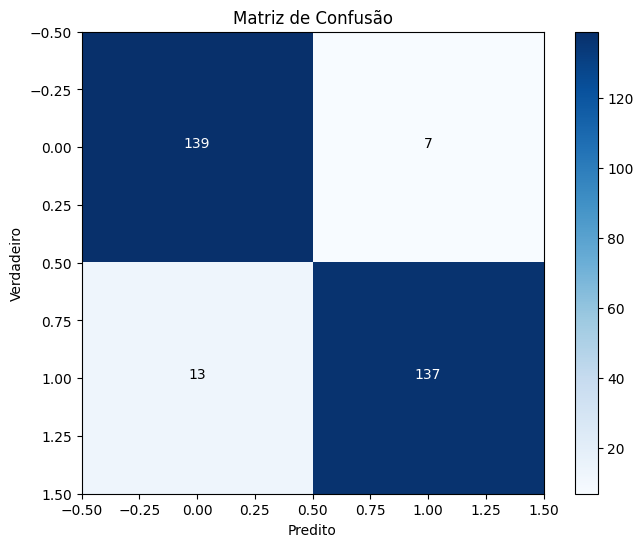

Matriz de Confusão: 
[[139   7]
 [ 13 137]]


In [376]:
import matplotlib.pyplot as plt

# Calcular a matriz de confusão
cm = confusion_matrix(y_teste, previsoes)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')

# Adicionar anotações na matriz de confusão
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

print(f'Matriz de Confusão: \n{cm}')